In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from matplotlib import pyplot as plt

from IPython.display import display, HTML

In [2]:
%%time
movies = pd.read_csv("./movies.csv")
movies.dropna(inplace = True)
movies.sort_values(by='movieId', inplace = True)
movies.reset_index(inplace = True, drop = True)

ratings = pd.read_csv('./ratings.csv')
ratings.dropna(inplace = True)
ratings.sort_values(by = 'movieId', inplace =True)
ratings.reset_index(inplace = True, drop = True)

Wall time: 20.3 s


In [3]:
%%time
movies['year'] = movies.title.str.extract("\((\d{4})\)")
movies.year = pd.to_datetime(movies.year, format = '%Y')
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

# genres_df = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
# genres_df = pd.DataFrame(genres_df, columns = ['genre'])
# movies = movies.join(movies.genres.str.get_dummies())
# movies.drop('genres', inplace = True, axis=1)

Wall time: 164 ms


In [4]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,97809,1,3.0,1213159631
1,106140,1,5.0,1359430429
2,106138,1,3.0,1028130533
3,70354,1,4.5,1297623340
4,70355,1,3.5,1201366614


## Collaborative Filtering

In [6]:
user_count = ratings['userId'].nunique()
movie_count = movies['movieId'].nunique()

print(user_count)
print(movie_count)

138493
27278


In [7]:
%%time
## Utility matrix
#util = pd.pivot_table(data = ratings, values = 'rating', index = 'userId', columns = 'movieId')

# Since we have 20 million data entries, we are going to take a sample of 5 million to make it easier to work with
data = ratings.iloc[:5000000,:]
#data = ratings.sample(frac = 0.249)
util = pd.pivot_table(data = data, values = 'rating', index= 'userId', columns = 'movieId')
#util = util.fillna(util.mean())

Wall time: 13.4 s


In [8]:
d = ratings.sample(frac=0.249)
d.shape

(4980065, 4)

In [9]:
means = np.array(util.mean(axis=1))
util_center = util.sub(means, axis = 0)
util_center = util_center.fillna(0)

In [10]:
print(util_center.sample(n=5))

movieId       1    2         3    4         5         6         7    8    \
userId                                                                     
7968     0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
36435    0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
89711    0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
124789   1.021978  0.0  1.021978  0.0  1.021978  1.021978  1.021978  0.0   
122673   0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   

movieId       9         10   ...  893  894  895  896  897       898       899  \
userId                       ...                                                
7968     0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.000000 -0.222222   
36435    0.000000  0.205882  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
89711    0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
124789   0.021978  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0

Since we are dealing with 5 million data user data, we are expecting our pivot table to be extremely sparse. 

In [11]:
util_center_matrix = util_center.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [13]:
print(100 * round(1- len(data) / float(user_count * movie_count), 4))

99.87


We see that our matrix is 99.87% sparse.

In [14]:
print(util_center.corrwith(util_center[901]).sort_values(ascending = False))

movieId
901    1.000000
900    0.125273
902    0.079545
899    0.070905
898    0.059436
         ...   
684   -0.025322
697   -0.025681
360   -0.026187
469   -0.026793
472   -0.026832
Length: 886, dtype: float64


In [15]:
u, sigma, vt = svds(util_center, which = 'LM', k = 100)
sigma = np.diag(sigma)

In [16]:
user_predicted_ratings = u.dot(sigma).dot(vt) + means.reshape(-1,1)

In [17]:
preds = pd.DataFrame(user_predicted_ratings, columns = util_center.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,893,894,895,896,897,898,899,900,901,902
0,3.685225,3.458334,3.670072,3.687605,3.679631,3.706910,3.675140,3.683063,3.684182,3.698825,...,3.682372,3.684023,3.683818,3.682010,3.684527,3.686395,3.678403,3.681655,3.682121,3.687669
1,4.252382,4.245581,4.157464,4.244092,4.168927,4.197855,4.257963,4.238847,4.220855,4.235985,...,4.250559,4.249703,4.249631,4.248974,4.254575,4.220181,4.204077,4.249307,4.245473,4.235073
2,4.004076,4.028629,4.092724,4.056558,4.065017,4.094259,3.984732,4.046335,4.010479,4.045746,...,4.032691,4.036254,4.036567,4.030182,4.038802,4.054778,4.041530,4.020495,4.034903,4.041526
3,3.556313,3.534547,3.601707,3.583972,3.583359,3.087559,3.599895,3.572185,3.564162,4.001937,...,3.569470,3.572596,3.571508,3.573038,3.580896,3.595622,3.636608,3.590042,3.577900,3.607314
4,4.141357,3.031353,4.004719,4.155967,4.107822,4.146133,4.260107,4.123130,4.130617,4.201011,...,4.144380,4.153831,4.150381,4.157269,4.163229,4.214478,4.346298,4.198924,4.157296,4.202694


In [18]:
test = ratings[ratings['userId'] == 12].iloc[:,:3]
test_full = test.merge(movies.iloc[:,:2], left_on = 'movieId', right_on = 'movieId')
test_recommend = movies[~movies['movieId'].isin(test_full['movieId'])].iloc[:,:2]

In [19]:
sorted_preds = pd.DataFrame(preds.iloc[12 - 1].sort_values(ascending = False))
test_recommend = test_recommend.merge(sorted_preds.reset_index(), left_on = 'movieId', right_on = 'movieId')

In [20]:
test_recommend.rename(columns = {11: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:20, :]

,movieId,title,Predictions
482,508,Philadelphia,3.706682
418,442,Demolition Man,3.699232
0,2,Jumanji,3.674215
519,546,Super Mario Bros.,3.672807
318,337,What's Eating Gilbert Grape,3.663876
48,58,"Postman, The (Postino, Il)",3.660172
201,216,Billy Madison,3.638388
247,265,Like Water for Chocolate (Como agua para choco...,3.629731
493,519,RoboCop 3,3.625194
308,327,Tank Girl,3.620672


In [21]:
def recommend(preds, userId, movies_df, ratings_df, num_recommendation):
    sorted_preds = pd.DataFrame(preds.iloc[userId - 1].sort_values(ascending = False))
    
    given_user = ratings_df[ratings_df['userId'] == userId].iloc[:,:3]
    full_user_data = given_user.merge(movies_df.iloc[:, :3], left_on = 'movieId', right_on = 'movieId')
    
    recommendations = movies_df[~movies['movieId'].isin(full_user_data['movieId'])].iloc[:,:3]
    recommendations = recommendations.merge(sorted_preds.reset_index(), left_on = 'movieId', right_on = 'movieId')
    recommendations = recommendations.rename(columns = {(userId - 1): 'Predictions' }).sort_values('Predictions', ascending = False)
    recommendations['Normalized Predictions'] = (recommendations['Predictions'] - recommendations['Predictions'].min()) /(
                                                recommendations['Predictions'].max()-recommendations['Predictions'].min())
    return full_user_data, recommendations.iloc[:num_recommendation,:]

In [22]:
watched, predictions = recommend(preds, 123, movies, ratings, 20)
print("The user watched:\n")
print(display(HTML(watched.to_html())))
print('\nWe will recommend the user:\n')
print(display(HTML(predictions.to_html())))

The user watched:



,userId,movieId,rating,title,genres
0,123,10,3.0,GoldenEye,Action|Adventure|Thriller
1,123,18,4.0,Four Rooms,Comedy
2,123,20,3.0,Money Train,Action|Comedy|Crime|Drama|Thriller
3,123,21,3.0,Get Shorty,Comedy|Crime|Thriller
4,123,27,3.0,Now and Then,Children|Drama
5,123,65,1.0,Bio-Dome,Comedy
6,123,102,3.0,Mr. Wrong,Comedy
7,123,104,3.0,Happy Gilmore,Comedy
8,123,121,4.0,"Boys of St. Vincent, The",Drama
9,123,135,1.0,Down Periscope,Comedy


None

We will recommend the user:



,movieId,title,genres,Predictions,Normalized Predictions
5,6,Heat,Action|Crime|Thriller,5.199966,1.000000
279,293,Léon: The Professional (a.k.a. The Professional) (Léon),Action|Crime|Drama|Thriller,5.192685,0.998273
26,32,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller,5.071032,0.969419
748,780,Independence Day (a.k.a. ID4),Action|Adventure|Sci-Fi|Thriller,5.069833,0.969135
591,608,Fargo,Comedy|Crime|Drama|Thriller,5.055816,0.965810
101,111,Taxi Driver,Crime|Drama|Thriller,5.053516,0.965265
352,367,"Mask, The",Action|Comedy|Crime|Fantasy,5.051345,0.964750
342,357,Four Weddings and a Funeral,Comedy|Romance,5.048115,0.963984
41,47,Seven (a.k.a. Se7en),Mystery|Thriller,5.043238,0.962827
304,318,"Shawshank Redemption, The",Crime|Drama,5.037912,0.961564


None


In [23]:
%%time
all_watch, all_preds = recommend(preds, 123,movies,ratings,movie_count)

Wall time: 123 ms


In [24]:
item_coverage = (all_preds.shape[0]/movie_count)
print(item_coverage)

0.03171053596304715


In [25]:
def coverage(preds, movies, ratings, movie_count, user_count, user_range, type):
    preds_length = []
    coverage = []
    for i in range(1, user_range):
        all_watch, all_preds = recommend(preds, i, movies, ratings, movie_count)
        preds_length.append(all_preds.shape[0])
    if (type == 'item'):
        return [length/movie_count for length in preds_length]
    elif (type == 'user'):
        return [user_r/user_count for user_r in range(1,user_range)]
    elif (type == 'catalog'):
        return (len(preds_length))/(movie_count, user_count)

In [26]:
%%time
item_coverage = coverage(preds,movies,ratings,movie_count,user_count,100,'item')
user_coverage = coverage(preds,movies,ratings,movie_count,user_count,100,'user')
#print(coverage(preds,movies,ratings,movie_count,data.shape[0],'catalog'))

Wall time: 24 s


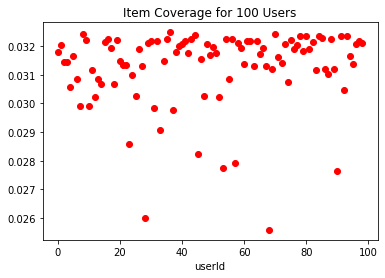

In [27]:
plt.title('Item Coverage for 100 Users')
plt.xlabel('userId')
plt.plot(item_coverage, 'ro')

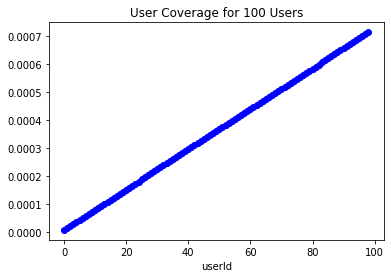

In [28]:
plt.title('User Coverage for 100 Users')
plt.xlabel('userId')
plt.plot(user_coverage, 'bo')

## Conclusion

This is a collaborative filtering matrix factorization movie recommender system using SVD to reduce the dimensionality of the pivot table calculated above. We do this because we have 20 million user data and we are sampling 5 million user data. Since we have so much data, we want to reduce dimensionality. This can be seen with how sparse our data was, even with sampling 5 million users. We found that the matrix was 99.9% sparse. This makes sense since movies don't all share similar genre tags. Similarly, users don't watch all movies. With how large and how sparse our matrix was, using SVD helps reduce dimensionality and gives us a sense of which users are watching similar things. This is done with collaborative filtering as we look at users who share similar movie patterns as other users and recommend them movie predictions. Since we are using SVD, however, we can expect that we will lose some crucial information about the user data.

From above, we see that given all of the information we have about userId: 112, we can predict them movies that they haven't seen and that are of similar genres. In the case of userId: 112, we can see that he is being recommended a lot of crime/thriller/mystery/action movies.

In [34]:
from surprise import SVD, SVDpp
from surprise.accuracy import rmse, mse
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split

In [36]:
reader = Reader(rating_scale=(0.5,5))
r_data = Dataset.load_from_df(ratings.iloc[:,:3], reader)

In [ ]:
%%time
benchmark = []
for algorithm in [SVD(), SVDpp()]:
    results = cross_validate(algorithm, r_data, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [38]:
%%time
results = cross_validate(SVD(), r_data, verbose = False)
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)

ERROR! Session/line number was not unique in database. History logging moved to new session 143


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

